## Initialization

In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Constants

In [2]:
PROJECT_ROOT = 'absolute-path-of-project-root'
TRAIN_MBTR_DIR = PROJECT_ROOT + "/data/processed/training_set/features"
TEST_MBTR_DIR = PROJECT_ROOT + "/data/processed/test_set/features"
TRAIN_SASA_DIR = PROJECT_ROOT + "/data/processed/training_set/label"
TEST_SASA_DIR = PROJECT_ROOT + "/data/processed/test_set/label"
MODELS_DIR = PROJECT_ROOT + "/models"
PLOTS_DIR = PROJECT_ROOT + "/plots"
WINDOW_SIZE = 1
SAVE_MODELS = False
RANDOM_STATE = 123

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import copy
import keras
from numpy.lib.stride_tricks import sliding_window_view
import random
from sklearn.model_selection import KFold
import pickle
import re
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Helper Functions

In [4]:
def evaluate_results(y, y_hat, return_values = False, show_outputs = True):
  if len(y.shape) > 2:
    y = y.reshape((y.shape[0], -1))
    y_hat = y_hat.reshape((y_hat.shape[0], -1))
  mae = mean_absolute_error(y, y_hat)
  mse = mean_squared_error(y, y_hat)
  rmse = mean_squared_error(y, y_hat, squared=False)
  if show_outputs:
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
  if return_values:
    return mae, mse, rmse

In [5]:
def load_model(model_name, num_feature, directory):
    """
    Loads the sepcified model and returns the object representing that model.

    This function is a utility function that loads any of the models used in
    this project. The function reads the model from the specified directory
    through methods applicable to the type of model.

    Parameters
    ----------
    model_name : str
        ``transfomer`` or``ensemble_model``, for simulation part or
        ``sasa_model`` for SASA calculation
    num_feature : int
        Number of features in the training data
    directory : str
        absolute or relative directory for saving the models

    Returns
    -------
    object
        The object of the corresponding model's class
    """
    if model_name == 'transformer' or model_name == 'sasa_model':
        model = keras.models.load_model(directory)
        return model
    elif model_name == 'ensemble':
        model = ensemble_model(num_feature)
        model.load_model(directory)
        return model

In [6]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

In [7]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_pc(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()
    y_pred.append(pred_sasa)
    y_true.append(y_test[(i+1) * timestep - 1])

  return mean_absolute_error(y_true, y_pred)

In [8]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_mbtr(mbtr_model, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)

  error = 0
  sim_steps = timestep - window_size - 1
  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    y_pred.append(data[-1])
    y_true.append(x_test[(i+1) * timestep - 1])

    # error = error + np.sum(np.abs(data[-1] - x_test[(i+1) * timestep - 1]))

  return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

## Load Data

In [9]:
def mbtr_ds_generator(directory):
  """
  Creates a dataset of the MBTR vectors.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. All the
  vectors are gathered in a dataset along with the duration of the
  simulations for the designs.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets

  Returns
  -------
  x : array of floats; shape (number of designs * duration, num_feature)
      The vector array of all the MBTRs in a sequence stacked row-wise
  timestep_size : list of int
      duration of each design for the MBTR files in the directory
  """
  ptr = 0
  timestep_size = []
  if directory[-1] != '/':
    directory = directory + '/'
  for mbtr_file in sorted(os.listdir(directory)):
    x_mbtr = pd.read_csv(directory + str(mbtr_file))
    timestep_size.append(x_mbtr.shape[0])
    if ptr == 0:
      x = np.array(x_mbtr.values.tolist())
      ptr = 1
    else:
      x = np.concatenate((x, np.array(x_mbtr.values.tolist())), axis = 0)
    # print("MBTR: ", mbtr_file, "Shape:", x.shape)

  # print("MBTR Shape:", x.shape)
  # print("timesteps: ", len(timestep_size))
  return x, timestep_size

def sasa_ds_generator(directory):
  """
  Creates a dataset of SASA values.

  This function reads all CSV data files containing the SASA values
  corresponding to different design configurations at different states.
  All the values are gathered in a dataset.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the SASA CSV datasets

  Returns
  -------
  array of floats; shape (number of designs * duration,)
      The array of all the SASA values in a sequence stacked row-wise
  """
  ptr = 0
  if directory[-1] != '/':
    directory = directory + '/'
  for sasa_file in sorted(os.listdir(directory)):
    # print("SASA: ", sasa_file)
    x_sasa = pd.read_csv(directory + str(sasa_file), sep=';')
    if ptr == 0:
          x = np.array(x_sasa['TOTAL'])
          ptr = 1
    else:
          x = np.concatenate((x, np.array(x_sasa['TOTAL'])), axis = 0)
  # print("SASA Shape:", x.shape)
  return x

def mbtr_mbtr_ds_generator(directory, window_size, sasa_dir = None, shuffle = False):
  """
  Creates a windowed dataset of the MBTR vectors, and SASA values if specified.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. Then,
  generates a sliding window based dataset pair of MBTRs. If specified
  the SASA values are also recorded.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets
  window_size: int
      The window size to create the data pairs
  sasa_dir : str or None; default: None
      absolute or relative directory of the SASA CSV datasets,
      if ``None`` SASA values are not considered
  shuffle : bool
      Used to decide whether or not to shuffle the data order

  Returns
  -------
  dataset_x : array of floats; shape (number of samples, window_size, num_feature)
      The vector array of all the MBTRs stacked in sliding window method
  dataset_y : array of floats; shape (number of samples, num_feature)
      The array of MBTR vectors of the next timesteps of the window
  y_sasa : arrary of floats;  shape (number of samples, 1)
      The array of all the SASA values for the next timesteps of the window
  sasa_zero : array of float; shape (number of designs, 1)
      The array of initial SASA values (1st timestep) for each design configuration
  """
  dataset_x = []
  dataset_y = []
  y_sasa = []
  sasa_zero = []
  i = 0
  j = 0
  mbtr, timestep_size = mbtr_ds_generator(directory)
  if sasa_dir is not None:
    sasa = sasa_ds_generator(sasa_dir)
    if shuffle == True:
      idx = np.arange(mbtr.shape[0])
      np.random.shuffle(idx)
      mbtr = mbtr[idx]
      sasa = sasa[idx]
    assert mbtr.shape[0] == sasa.shape[0], "MBTR and SASA have mismatching shapes"
  elif shuffle == True:
    np.random.shuffle(mbtr)

  for i in range(len(timestep_size)):
    if i == 0:
        z = 0
    else:
        z = sum(timestep_size[:i])
    for j in range(z, z + timestep_size[i] - window_size):
      dataset_x.append(mbtr[j : j + window_size])
      dataset_y.append(mbtr[j + window_size])
      if not sasa_dir is None:
        y_sasa.append(sasa[j + window_size])
    if not sasa_dir is None:
      sasa_zero.append(sasa[z])
  if not sasa_dir is None:
    return np.array(dataset_x), np.array(dataset_y), np.array(y_sasa), np.array(sasa_zero)
  return np.array(dataset_x), np.array(dataset_y)

def get_X_predicted_and_y(mbtr_model):
  X, timesteps = mbtr_ds_generator(TRAIN_MBTR_DIR)
  Y = sasa_ds_generator(TRAIN_SASA_DIR)
  X_predicted = []
  labels = []
  for i in range(len(timesteps)):
    start = sum(timesteps[:i])
    end = start + timesteps[i] - 1
    current_data = X[start:start+WINDOW_SIZE]
    current_position = start + WINDOW_SIZE
    while current_position < end:
      X_predicted.append(mbtr_model.predict(np.expand_dims(current_data, axis=0)))
      labels.append(Y[current_position])
      current_data = np.concatenate((current_data[1:], X_predicted[-1]), axis=0)
      current_position = current_position + 1
  return np.array(X_predicted), np.array(labels)

## Train models

In [10]:
x_train, y_train, y_sasa_train, sasa_zero_train = mbtr_mbtr_ds_generator(TRAIN_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TRAIN_SASA_DIR, shuffle = False)
x_test, y_test, y_sasa_test, sasa_zero_test = mbtr_mbtr_ds_generator(TEST_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TEST_SASA_DIR, shuffle = False)
# y_train = sasa_ds_generator(TRAIN_SASA_DIR)
# y_test = sasa_ds_generator(TEST_SASA_DIR)
x_train.shape, y_train.shape, y_sasa_train.shape, x_test.shape, y_test.shape, y_sasa_test.shape

((24653, 1, 72), (24653, 72), (24653,), (3588, 1, 72), (3588, 72), (3588,))

In [11]:
x_train.std()

2906.885815913697

In [12]:
x_train_standardized = (x_train - x_train.mean()) / x_train.std()
x_test_standardized = (x_test - x_train.mean()) / x_train.std()
x_train_standardized.shape, x_test_standardized.shape

((24653, 1, 72), (3588, 1, 72))

### MBTR Training

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

In [ ]:
models = [LinearRegression,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          ExtraTreesRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'XGB',
                'AdaBoost',
                'GBM',
                'ETR',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

In [ ]:
indices = list(range(len(x_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = ensemble_model_custome(72, models[i], models_names[i])

  print("Model Name: ", models_names[i])

  if model.model_exists():
    model.load_model()
  else:
    model.train(x_train[indices], y_train[indices])

  print("Train set: ")
  evaluate_results(model.predict(x_train), y_train)
  print("Test set: ")
  evaluate_results(model.predict(x_test), y_test)
  print("Test set error of last timestep: ", calc_error_mbtr(model))

  if not model.model_exists() and SAVE_MODELS == True:
    model.save()

  print("-----------------------------\n")

Model Name:  LR
Train set: 
MAE:  1.4537481451747365
MSE:  48.79655607252665
RMSE:  1.8729050957768392
Test set: 
MAE:  1.4455889639066135
MSE:  48.31632810141629
RMSE:  1.8539849825636365
Test set error of last timestep:  (7.438863320096412, 8.546221231579375)
-----------------------------

Model Name:  XGB


100%|██████████| 72/72 [00:14<00:00,  4.85it/s]


Train set: 
MAE:  2.234291046181376
MSE:  950.0577279772838
RMSE:  7.4031269044543615
Test set: 
MAE:  1.8289397323381194
MSE:  72.34747555951152
RMSE:  2.8668701965258014
Test set error of last timestep:  (13.519106231060558, 16.495920714078807)
-----------------------------

Model Name:  AdaBoost


100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Train set: 
MAE:  9.556370709546677
MSE:  2728.763426082531
RMSE:  12.403162094022171
Test set: 
MAE:  7.899465625131989
MSE:  1612.0605328769993
RMSE:  10.648654479954722
Test set error of last timestep:  (19.981241426508586, 29.351043854136307)
-----------------------------

Model Name:  GBM


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Train set: 
MAE:  1.5431439172179338
MSE:  59.1906194046925
RMSE:  2.004326169147462
Test set: 
MAE:  1.8721730572416722
MSE:  77.70295113408855
RMSE:  2.8058094864278313
Test set error of last timestep:  (13.661064813929896, 17.281595993064254)
-----------------------------

Model Name:  ETR


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


Train set: 
MAE:  0.0156634733804817
MSE:  0.18640554477846713
RMSE:  0.1233221922717193
Test set: 
MAE:  1.7124855992649994
MSE:  76.048265485992
RMSE:  2.33847643816307
Test set error of last timestep:  (9.509305330789624, 13.22896537192834)
-----------------------------

Model Name:  SVR


100%|██████████| 72/72 [10:09<00:00,  8.47s/it]


Train set: 
MAE:  31.166240954230805
MSE:  233543.58580304577
RMSE:  100.40464161647941
Test set: 
MAE:  5.381345072248263
MSE:  4465.3636083784895
RMSE:  11.576327453886385
Test set error of last timestep:  (35.35847814502141, 44.04513658325014)
-----------------------------

Model Name:  KNR


100%|██████████| 72/72 [00:04<00:00, 17.98it/s]


Train set: 
MAE:  1.2548664007902157
MSE:  37.46049585970088
RMSE:  1.6193691906658796
Test set: 
MAE:  1.73139540784572
MSE:  66.71646470662715
RMSE:  2.614081213753936
Test set error of last timestep:  (12.781859326851785, 15.950559951657084)
-----------------------------

Model Name:  DTR


100%|██████████| 72/72 [00:05<00:00, 12.30it/s]


Train set: 
MAE:  0.015357211882944501
MSE:  0.1863281717598512
RMSE:  0.12329993891985966
Test set: 
MAE:  2.0531406301232704
MSE:  100.97382062614196
RMSE:  3.12843891990139
Test set error of last timestep:  (8.515094996442748, 12.545666075714614)
-----------------------------

Model Name:  RFR


100%|██████████| 72/72 [02:47<00:00,  2.33s/it]


Train set: 
MAE:  0.6327894786555807
MSE:  9.600682506221679
RMSE:  0.8247390179121952
Test set: 
MAE:  1.8341029901025365
MSE:  76.94693071362319
RMSE:  2.780417557586492
Test set error of last timestep:  (13.295245546766491, 17.942367516318814)
-----------------------------



### SASA Training

#### Train different machine learning models

In [14]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

LR_MBTR = ensemble_model_custome(72, LinearRegression, 'LR')
LR_MBTR.load_model()

In [ ]:
models = [LinearRegression,
          ExtraTreesRegressor,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'ETR',
                'XGB',
                'AdaBoost',
                'GBM',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

##### Train with original MBTR values

In [ ]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/original-data-pc.csv")

indices = list(range(len(y_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(y_train[indices], y_sasa_train[indices])
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/original-data-pc.csv", index=False)

Model Name:  LR
Train set: 
MAE:  958.1319140145897
MSE:  1548575.145374697
RMSE:  1244.4175928420077
Test set: 
MAE:  965.5738165032197
MSE:  1456512.3682281384
RMSE:  1206.860542162241
Test set pc error:  5886.020867708652
-----------------------------

Model Name:  ETR
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1313.1570049252718
MSE:  3947885.080982307
RMSE:  1986.9285545741968
Test set pc error:  3285.2815592447914
-----------------------------

Model Name:  XGB
Train set: 
MAE:  580.1716417626658
MSE:  574546.5713489712
RMSE:  757.9885034411611
Test set: 
MAE:  1663.8787516548216
MSE:  6371974.5607444905
RMSE:  2524.2770372414534
Test set pc error:  4109.930989583333
-----------------------------

Model Name:  AdaBoost
Train set: 
MAE:  4506.554959155434
MSE:  30541422.179617602
RMSE:  5526.429424105369
Test set: 
MAE:  4560.609858060055
MSE:  31992983.90653347
RMSE:  5656.234074588274
Test set pc error:  5231.828816597186
-----------------------------

Model Nam

##### Train with predicted MBTR values

In [15]:
X_sasa, Y_sasa = get_X_predicted_and_y(LR_MBTR)

In [16]:
X_sasa = X_sasa.squeeze()

In [17]:
X_sasa.shape, Y_sasa.shape

((24546, 72), (24546,))

In [ ]:
indices = list(range(len(X_sasa)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(X_sasa[indices], Y_sasa[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  evaluate_results(model.predict(y_test), y_sasa_test)
  print("Test set pc error: ", calc_error_pc(LR_MBTR, model))
  print("-----------------------------\n")

Model Name:  LR
Predicted train set: 
MAE:  1714.1646596367082
MSE:  4926551.301893948
RMSE:  2219.5835874987783
Train set: 
MAE:  188284.74288800306
MSE:  3832212725957.573
RMSE:  1957603.822523233
Test set: 
MAE:  440619.46238832263
MSE:  9456242696229.168
RMSE:  3075100.4367709956
Test set pc error:  2735.594082338927
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  6811.624542023561
MSE:  73149494.37036988
RMSE:  8552.74776725994
Test set: 
MAE:  6071.121770180114
MSE:  61469114.35139377
RMSE:  7840.2241263495625
Test set pc error:  1681.2798697916667
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  600.7783488980193
MSE:  593059.0708206508
RMSE:  770.1032858134361
Train set: 
MAE:  8275.508118089236
MSE:  104556525.59334746
RMSE:  10225.288533501021
Test set: 
MAE:  7828.739435270346
MSE:  94986604.68108216
RMSE:  9746.107155222651
Test set pc error:  1963.4163411458333
---------------

##### Train with original + predicted MBTR values

In [ ]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/all-data-pc.csv")

all_X = np.concatenate((X_sasa, y_train), axis=0)
all_y = np.concatenate((Y_sasa, y_sasa_train), axis=0)
print(all_X.shape, all_y.shape)
indices = list(range(len(all_X)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(all_X[indices], all_y[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/all-data-pc.csv", index=False)

(49199, 72) (49199,)
Model Name:  LR
Predicted train set: 
MAE:  2100.5314848482262
MSE:  7192750.863675269
RMSE:  2681.9304360246315
Train set: 
MAE:  1568.4747019465053
MSE:  5008470.662051671
RMSE:  2237.961273581755
Test set: 
MAE:  1493.2115256340214
MSE:  3967547.597752501
RMSE:  1991.8703767445563
Test set pc error:  2663.0902970215225
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1210.5189065548357
MSE:  3343712.8628312177
RMSE:  1828.582200184399
Test set pc error:  1448.6954231770826
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  720.735510941192
MSE:  845222.8049729663
RMSE:  919.3599974835572
Train set: 
MAE:  694.2481848050948
MSE:  837096.4105793402
RMSE:  914.9297298587145
Test set: 
MAE:  1719.4329111360787
MSE:  6915614.789476839
RMSE:  2629.755652047703
Test set pc error:  2521.3681640625
-----------------------------

Model N

#### Plotting the performance

In [19]:
mbtr_model = LR_MBTR
sasa_model = ExtraTreesRegressor(random_state=RANDOM_STATE).fit(all_X, all_y)

In [20]:
mem = []

In [23]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE, baseline=False):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  print("NAME", "PRED", "TRUE", "PERC")

  for i in range(12):
    if len(mem) <= i:
      pointer = (i * timestep)
      data = x_test[pointer : pointer + WINDOW_SIZE]
      for j in (range(sim_steps)):
        next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
        data = np.concatenate((data, next_mbtr), axis = 0)
      pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
      pred_sasa = pred_sasa.squeeze()
      mem.append(pred_sasa)
    else:
      pred_sasa = mem[i]

    print(titles[i], pred_sasa, y_test[(i+1) * timestep - 1], abs(pred_sasa - y_test[(i+1) * timestep - 1]) / y_test[(i+1) * timestep - 1])

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

  plt.legend(titles)

  plt.xlabel('Predicted SASA')
  plt.ylabel('True SASA')
  plt.axline((60000,60000), slope=1, linestyle='--', color='black')
  if baseline:
    plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_baseline.png", dpi=300)
  else:
    plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_" + str(WINDOW_SIZE) + ".png", dpi=300)
  plt.show()

NAME PRED TRUE PERC
GEM11 74596.452421875 74784.6875 0.0025170270066983812
GEM41 81439.73640625 80337.0703125 0.01372549545883091
NCL11 66554.329296875 63675.27734375 0.0452145962016386
NHQ51 61125.0663671875 60745.85546875 0.006242580592721779
OQL11_3 67332.0582421875 66567.953125 0.011478573116897239
OQL13v2_3 74074.296640625 75432.515625 0.018005749551389096
PAN11v2_3b 73945.3359375 74523.9375 0.007763969295100651
PAN14v2_3 75171.6959375 76080.1484375 0.011940729857359505
PAN31_3 78324.7687109375 82504.890625 0.050665140967969174
S1_11R2_3 66968.94890625 68690.3203125 0.025059883232728855
S1_11R4_3 67220.5847265625 64980.51953125 0.03447287296980179
S1_15_3 73986.0134375 75070.2578125 0.01444306182760247


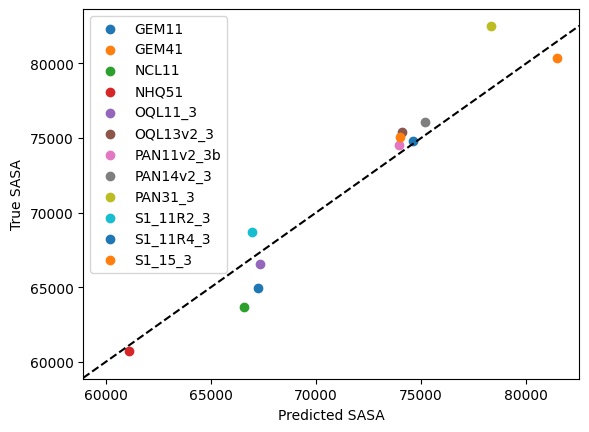

In [24]:
plot_true_and_predicted_sasa(mbtr_model, sasa_model)